In [18]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt

import GPy

from athena.active import ActiveSubspaces

import warnings
warnings.filterwarnings('ignore')
import tikzplotlib as tpl

Create the data to build the active subspace

In [19]:
np.random.seed(42)

# Global parameters
n_samples = 1000
input_dim = 2

# Generate uniformly distributed inputs
lb = -1 * np.ones(input_dim)
ub = 1 * np.ones(input_dim)
X = np.vstack(np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(input_dim)]).T)

# Define the quantity of interest and compute the gradients
def f(x, normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    return (x[:,0]+2*x[:,1])**2+1*(x[:, 0]-2*x[:, 1])-3

df = egrad(f)(X)

Computing the active subspace with ATHENA

In [20]:
# Compute the active subspace
asub = ActiveSubspaces(dim=1)
asub.fit(gradients=df)

# Display eigenvalues of covariance matrix
print(asub.evals)



[36.77353779  3.03811201]


Generate sample of the averaged QoI over the active subspace

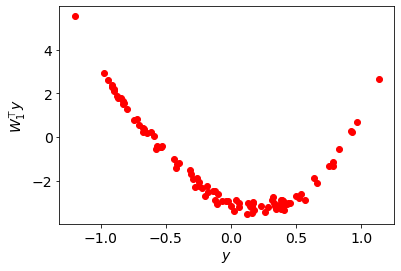

In [21]:
def InactiveSubspaceSampling(active, ss, f_out, N=1):
    return np.array([f_out(ss.inverse_transform(active)[0]) for i in range(N)])

Ntr = 100
Xtr = np.vstack(np.array([np.random.uniform(lb[i], ub[i], Ntr) for i in range(input_dim)]).T)
Ytr = asub.transform(Xtr)[0]
fYZ = InactiveSubspaceSampling(Ytr, asub, f, 25)
Ftr = np.mean(fYZ,axis=0)

plt.figure(figsize=(6, 4))
plt.scatter(Ytr, Ftr, c='r', label='Optimal profile')
plt.xlabel("$y$")
plt.ylabel("$W_1^\\top y$")

tpl.save("optprofile.tex")
plt.show()

Fit a GP predictor on the active subspace with GPy

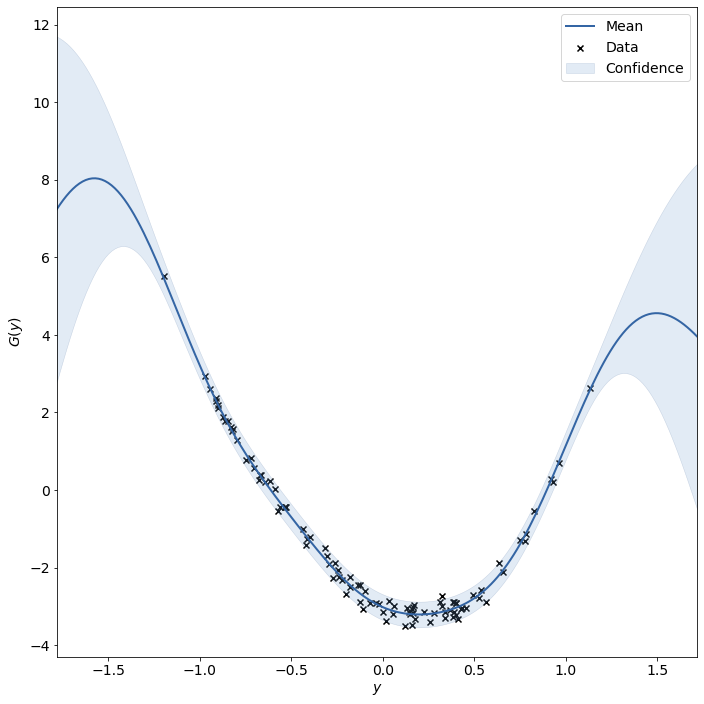

In [22]:
sig = 0.1
gp = GPy.models.GPRegression(Ytr, Ftr.reshape(-1, 1), noise_var=sig)

gp.constrain_positive('')
gp.optimize_restarts(5, verbose=False)

gp.plot(figsize=(10,10))
plt.xlabel("$y$")
plt.ylabel("$G(y)$")
tpl.save("gpfit.tex")
plt.show()


Compare the GP fit with the restriction of the original function (we see that it is not a conservative approximation)

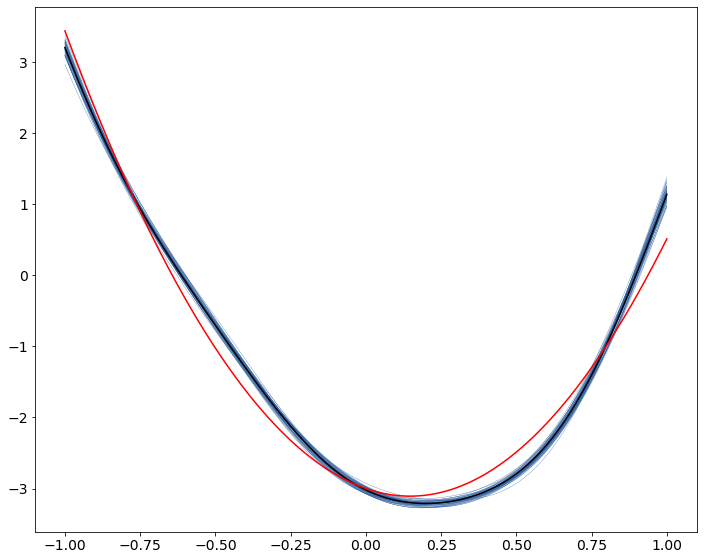

In [23]:
# Plot the GP 
t = np.linspace(-1,1,100).reshape((100,1))
Ymean_b = gp.predict(t) 
gp.plot_samples(samples=50, plot_limits=[-1,1], figsize=(10,8))
plt.plot(t,Ymean_b[0].flatten(),c="k")


# Plot the exact function
subeig = asub.evects[:,0].reshape((1,2))
exactf = []

nsamp = 400
xx = np.linspace(-1,1,nsamp)
for i in range(nsamp):
    exactf.append(f(xx[i] * subeig))

plt.plot(xx,exactf,c="r")
plt.show()

Computing a biased surrogate with $\tau = 0.95$ target conservativeness level

In [24]:
import casm

biased_gp, bias = casm.computeBiasedSurrogate(Ytr,Ftr,fYZ,0,10,1e-2,0.95)

print(f"The bias is {bias}")

Iteration 0 : fit done
Iteration 0 : bias = 5.0, success probability = 1.0
Iteration 1 : fit done
Iteration 1 : bias = 2.5, success probability = 1.0
Iteration 2 : fit done
Iteration 2 : bias = 1.25, success probability = 0.870358
Iteration 3 : fit done
Iteration 3 : bias = 1.875, success probability = 0.9898119999999999
Iteration 4 : fit done
Iteration 4 : bias = 1.5625, success probability = 0.940214
The bias is 1.5625


Compare the biased GP fit with the restriction of the original function : it is now conservative all over the active subspace (and should be conservative over at least 95% of the full space)

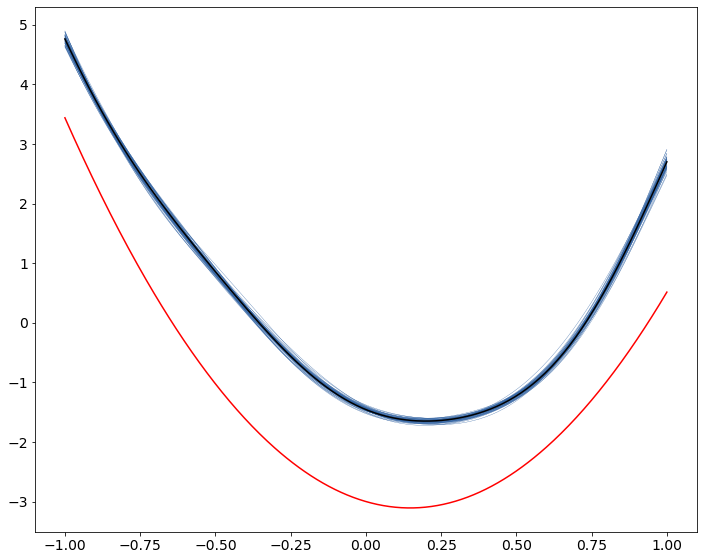

In [25]:
t = np.linspace(-1,1,100).reshape((100,1))
Ymean_b = biased_gp.predict(t)
biased_gp.plot_samples(samples=50, plot_limits=[-1,1], figsize=(10,8))
plt.plot(t,Ymean_b[0].flatten(),c="k")


plt.plot(xx,exactf,c="r")
plt.show()

Plot the contour lines of exact feasible set, and the feasible sets determined from the unbiased and biased GP fits

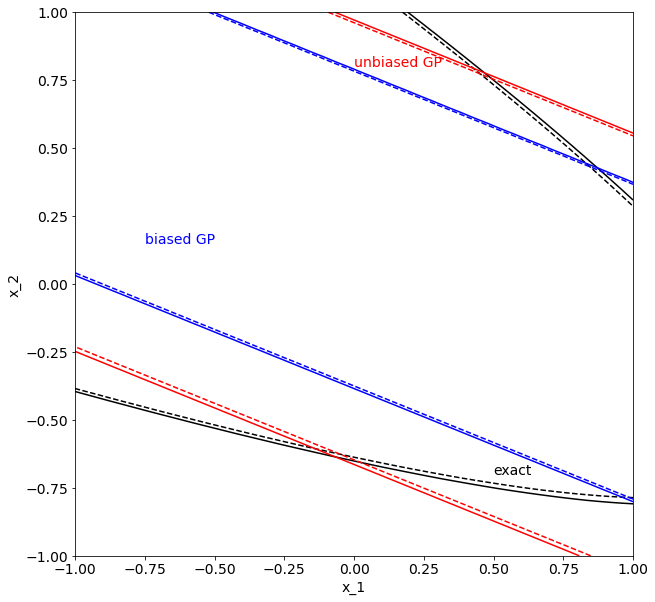

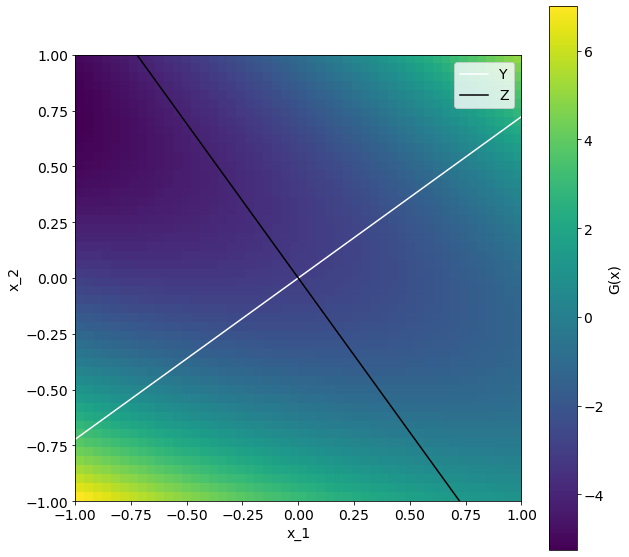

In [26]:
meshX, meshY = np.meshgrid(np.linspace(-1,1,50),np.linspace(-1,1,50))
argin = np.vstack((meshX.flatten(),meshY.flatten())).T
fargin = f(argin).reshape((50,50), order="C")
vargin = biased_gp.predict(asub.transform(argin)[0])[0].reshape((50,50), order="C")
gargin = gp.predict(asub.transform(argin)[0])[0].reshape((50,50), order="C")

plt.figure(figsize=(10,10))
#plt.imshow(fargin,extent=[-1,1,-1,1],origin="lower")
plt.contour(meshX,meshY,fargin,[-0.1,0],colors="k",linestyle="dashed")
plt.contour(meshX,meshY,vargin,[-0.05,0],colors="b",linestyle="solid")
plt.contour(meshX,meshY,gargin,[-0.1,0],colors="r",linestyle="solid")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.annotate('exact',(0.5,-0.7))
plt.annotate('unbiased GP',(0,0.8),color="r")
plt.annotate('biased GP',(-0.75,0.15),color="b")
tpl.save("cons.tex")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(fargin,extent=[-1,1,-1,1],origin="lower")
plt.colorbar(label="G(x)")
plt.plot([-1,1],[-0.723,0.723],color="w",label="Y")
plt.plot([-0.723,0.723],[1,-1],color="k",label="Z")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
tpl.save("active.tex")
plt.show()

Compute quality metrics

In [27]:
# Observed Conservativeness
M = 10000
Xsample = np.vstack(np.array([np.random.uniform(lb[i], ub[i], M) for i in range(input_dim)]).T)
yk = asub.transform(Xsample)[0]
fhat = biased_gp.predict(yk.reshape((M,1)))[0].reshape((M,1)) # approx constraint
fyz = f(asub.inverse_transform(yk.reshape((M,1)))[0]) # exact constraint
np.sum(fhat.flatten() > fyz.flatten())/M



0.9458

In [28]:
# Unfeasibility Ratio
fhat = biased_gp.predict(yk.reshape((M,1)))[0].reshape((M,1)) # approx constraint
fyz = f(asub.inverse_transform(yk.reshape((M,1)))[0]) # exact constraint
np.sum(np.logical_and(fhat.flatten() < 0, fyz.flatten() > 0))/np.sum(fhat.flatten() < 0)

0.0017340038148083927